# Risk Tolerance Prediction

## Problem Statement:
Predicting investment risk tolerance of individual investors based on their demographic, financial and behavioural characteristics.

## Data:
US Federal Reserve conducts trienneial Survey of Consumer Finances, which is an exhaustive survey of US-based households (selected randomly from all economic strata) to collect wide variety of information including demographic, financial and behavioural aspects. This project used the data from the latest 2019 edition of the survey. (Survey Documentation link: https://www.federalreserve.gov/econres/scfindex.htm)

## Loading Libraries

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import pylab
from datetime import datetime
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [254]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sb.set_theme('deep')

ValueError: context must be in paper, notebook, talk, poster

## Data Collection

In [176]:
data = pd.read_csv('SCFP2019.csv')

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28885 entries, 0 to 28884
Columns: 351 entries, YY1 to NINCQRTCAT
dtypes: float64(74), int64(277)
memory usage: 77.4 MB


In [178]:
data.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


The 'Risk Tolerance' value is not explicitly present in the survey data. However, as I trawled through the detailed documentation of the survey, there are two cruical variables 'EQUITY' and 'FIN' which can be used to compute the Risk Tolerance of the respondents as:

<b>RiskTolerance = % of EQUITY investments in total FIN</b>, where

- EQUITY : value of total equity investments (includes direct equities, stock mutual funds and equity weightage in quasi-liquid retirement assets and other financial assets)
- FIN : value of total financial assets

We'll use this as the target column in our modelling. 

In [179]:
data['RiskTolerance'] = data['EQUITY']/data['FIN']

In [180]:
#checking for null values in RiskTolerance column 
data[data['RiskTolerance'].isnull()][['EQUITY','FIN','RiskTolerance']]

,EQUITY,FIN,RiskTolerance
615,0.0,0,NaN
616,0.0,0,NaN
617,0.0,0,NaN
618,0.0,0,NaN
619,0.0,0,NaN
...,...,...,...
28640,0.0,0,NaN
28641,0.0,0,NaN
28642,0.0,0,NaN
28643,0.0,0,NaN


In [181]:
# For those with FIN=0, RiskTolerance became null (as shown above). Thus, we can't but delete all such rows
data.dropna(subset=['RiskTolerance'],axis=0, inplace=True)

After meticulously reviewing the exhaustive list of 351 survey variables (from documentation given on the Fed site) basis my 5 years of work experience in the Personal Finance space, the following intuitive features are selected for modelling:

DEMOGRAPHIC FEATURES:
1. HHSEX: 1 male; 2 female
2. AGE: Age of the respondent
3. EDCL(Education category): 1=no high school diploma/GED, 2=high school diploma or GED, 3=some college or Assoc. degree, 4=Bachelors degree or higher
4. MARRIED (marital status): 1 represents married/living with partner and 2 represents unmarried/not living with partner.
5. KIDS: number of children (including natural children/step-children/foster children of reference person/spouse/partner)
6. OCCAT2(Occupation category): 1=managerial/professional 2=technical/sales/services, 3=other (incl. production/craft/repair workers, operators, laborers, farmers, foresters, fishers) 4=not working

FINANCIAL FEATURES:
7. INCOME : total Household income in the previous calendar year
8. NETWORTH = total assets - total liabilities of the household
9. ANYPEN: 1, if the reference person/spouse has any type of pension. 0, otherwise. 
10. EXPENSHILO: Households overall expenses over last 12 months: 1=unusually high, 2=unusually low, 3=normal
11. BNKRUPLAST5 (Bankruptcy in last 5 years): 1 if yes, 0 if no
12. FORECLLAST5 (Foreclosure in last 5 years): 1 if yes, 0 if no

BEHAVIOURAL FEATURES:
13. SPENDMOR (Will you spend more if your asset value appreciates): 1=agree strongly, 2=agree somewhat, 3=neither agree nor disagree, 4=disagree somewhat, 5=disagree strongly
14. SPENDLESS (Will you spend less if your asset value depreciates): 1=agree strongly, 2=agree somewhat, 3=neither agree nor disagree, 4=disagree somewhat, 5=disagree strongly
15. KNOWL (Financial knowledge level of the respondent - self-assessed): -1=not at all knowledgeable...10=vary knowledgeable
16. YESFINRISK: If willing to take substantial financial risks expecting to earn substantial returns, 1. Else 0.
17. NOFINRISK: If not willing to take any financial risks, 1. Else 0.

In [182]:
keep_cols = ['HHSEX','AGE','EDCL','MARRIED','KIDS','OCCAT2','INCOME','NETWORTH','ANYPEN','EXPENSHILO','BNKRUPLAST5','FORECLLAST5','SPENDMOR','SPENDLESS','KNOWL','YESFINRISK','NOFINRISK','RiskTolerance']

data_final = data[keep_cols]
data_final.head()

,HHSEX,AGE,EDCL,MARRIED,KIDS,OCCAT2,INCOME,NETWORTH,ANYPEN,EXPENSHILO,BNKRUPLAST5,FORECLLAST5,SPENDMOR,SPENDLESS,KNOWL,YESFINRISK,NOFINRISK,RiskTolerance
0,2,75,4,2,0,1,67195.78150,2153600.0,0,1,0,0,4,2,6,0,0,0.406244
1,2,75,4,2,0,1,57014.60249,2116200.0,0,1,0,0,4,2,6,0,0,0.258691
2,2,75,4,2,0,1,51924.01298,2145000.0,0,1,0,0,4,2,6,0,0,0.233976
3,2,75,4,2,0,1,41742.83396,2552500.0,0,1,0,0,4,2,6,0,0,0.285431
4,2,75,4,2,0,1,50905.89508,2176200.0,0,1,0,0,4,2,6,0,0,0.250969


In [183]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28559 entries, 0 to 28884
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HHSEX          28559 non-null  int64  
 1   AGE            28559 non-null  int64  
 2   EDCL           28559 non-null  int64  
 3   MARRIED        28559 non-null  int64  
 4   KIDS           28559 non-null  int64  
 5   OCCAT2         28559 non-null  int64  
 6   INCOME         28559 non-null  float64
 7   NETWORTH       28559 non-null  float64
 8   ANYPEN         28559 non-null  int64  
 9   EXPENSHILO     28559 non-null  int64  
 10  BNKRUPLAST5    28559 non-null  int64  
 11  FORECLLAST5    28559 non-null  int64  
 12  SPENDMOR       28559 non-null  int64  
 13  SPENDLESS      28559 non-null  int64  
 14  KNOWL          28559 non-null  int64  
 15  YESFINRISK     28559 non-null  int64  
 16  NOFINRISK      28559 non-null  int64  
 17  RiskTolerance  28559 non-null  float64
dtypes: flo

In [184]:
# checking for null values in data_final
data_final[data_final.columns[data_final.isnull().sum()>0]]

""
0
1
2
3
4
...
28880
28881
28882
28883


In [185]:
x = data_final.drop('RiskTolerance', axis=1)
y = data_final['RiskTolerance']

In [186]:
# Splitting Train & Test Data --> to prevent data leakage from test data into train data & thus avoiding overfitting
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

print(train_data.shape, test_data.shape)
train_data.head()

(22847, 18) (5712, 18)


,HHSEX,AGE,EDCL,MARRIED,KIDS,OCCAT2,INCOME,NETWORTH,ANYPEN,EXPENSHILO,BNKRUPLAST5,FORECLLAST5,SPENDMOR,SPENDLESS,KNOWL,YESFINRISK,NOFINRISK,RiskTolerance
25885,1,61,4,1,1,1,374565.57600,9197881.0,1,3,0,0,5,4,9,0,0,0.477644
8088,1,76,4,1,0,3,53960.24878,832500.0,1,1,0,0,5,1,5,0,0,0.393474
13999,2,93,2,2,0,4,53145.75446,1730000.0,1,3,0,0,5,1,8,0,1,0.948454
28515,1,80,1,2,1,3,87558.13954,220110.0,0,3,0,0,5,5,5,0,1,0.000000
5383,1,58,4,1,0,4,509058.95080,43903000.0,1,3,0,0,2,1,10,0,0,0.589254


## EDA & Feature Engineering

Features play the significant role in any machine learning model. The following columns need be encoded/modified to get them ready for modelling:

#### HHSEX: Convert into binary column 'sex_male' (1 if male, 0 if female)

Text(0,0.5,'Risk Tolerance')

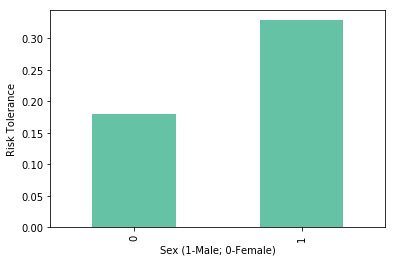

In [255]:
train_data['sex_male'] = train_data['HHSEX'].map({1:1,2:0})

train_data.groupby('sex_male')['RiskTolerance'].mean().plot(kind='bar')
plt.xlabel('Sex (1-Male; 0-Female)')
plt.ylabel('Risk Tolerance')

#### AGE: Check if normally distributed, and apply transformations if need be

In [188]:
train_data.AGE.describe()

count    22847.000000
mean        53.266643
std         16.237855
min         18.000000
25%         41.000000
50%         54.000000
75%         65.000000
max         95.000000
Name: AGE, dtype: float64

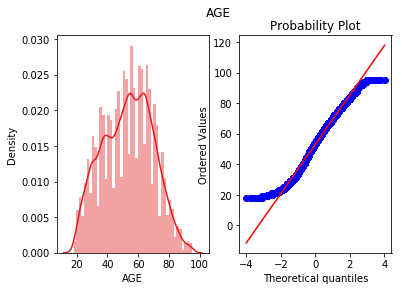

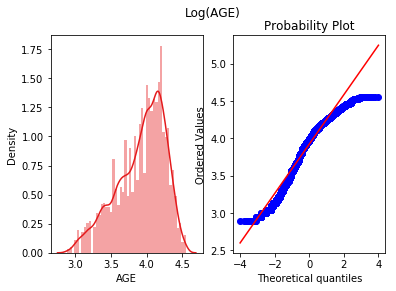

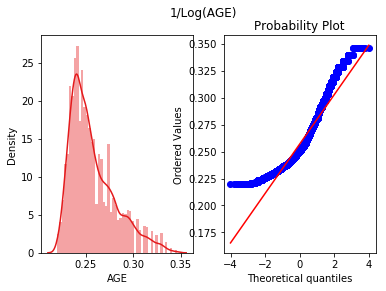

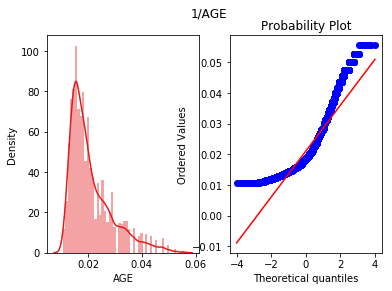

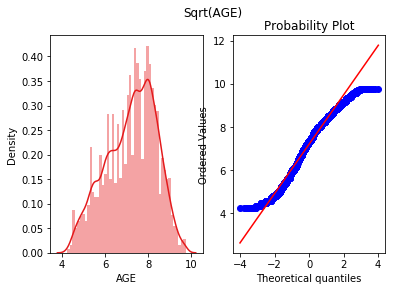

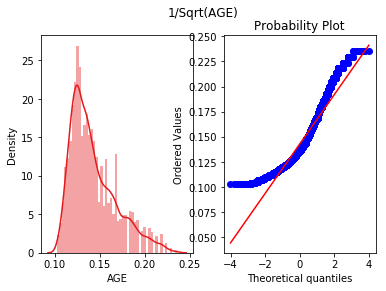

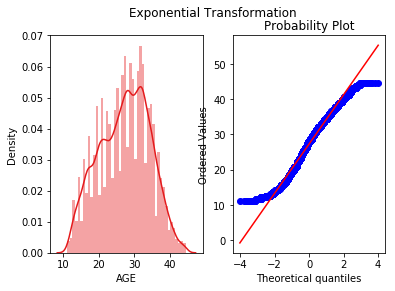

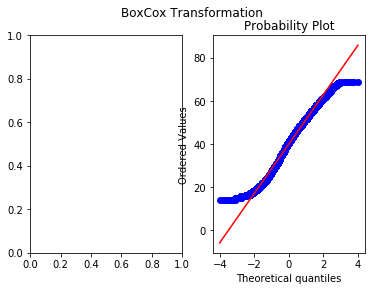

In [189]:
# Checking if Age is normally distributed, and applying transformations to convert it into a normal distribution
fig, ax = plt.subplots(1,2)
sb.distplot(train_data.AGE, ax = ax[0])
stats.probplot(train_data.AGE, dist='norm', plot = pylab)
plt.suptitle('AGE')
plt.show()

# Log Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(np.log(train_data.AGE), ax = ax[0])
stats.probplot(np.log(train_data.AGE), dist='norm', plot = pylab)
plt.suptitle('Log(AGE)')
plt.show()

# 1/log(x) Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(1/np.log(train_data.AGE), ax = ax[0])
stats.probplot(1/np.log(train_data.AGE), dist='norm', plot = pylab)
plt.suptitle('1/Log(AGE)')
plt.show()

# Reciprocal Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(1/(train_data.AGE), ax = ax[0])
stats.probplot(1/(train_data.AGE), dist='norm', plot = pylab)
plt.suptitle('1/AGE')
plt.show()

# Square root Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(np.sqrt(train_data.AGE), ax = ax[0])
stats.probplot(np.sqrt(train_data.AGE), dist='norm', plot = pylab)
plt.suptitle('Sqrt(AGE)')
plt.show()

# 1/Square root Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(1/np.sqrt(train_data.AGE), ax = ax[0])
stats.probplot(1/np.sqrt(train_data.AGE), dist='norm', plot = pylab)
plt.suptitle('1/Sqrt(AGE)')
plt.show()

# Exponential Transformation
fig, ax = plt.subplots(1,2)
sb.distplot(train_data.AGE**(1/1.2), ax = ax[0])
stats.probplot(train_data.AGE**(1/1.2), dist='norm', plot = pylab)
plt.suptitle('Exponential Transformation')
plt.show()

# BoxCox Transformation
fig, ax = plt.subplots(1,2)
stats.probplot(stats.boxcox(train_data.AGE)[0], dist='norm',plot=pylab)
plt.suptitle('BoxCox Transformation')
plt.show()

As Age column itself looks closer to Normal distribution curve, compared to any of its transformed versions, we will stick with the original Age column without any transformation.

#### MARRIED: Convert into binary column 'IsMarried' (1 if male, 0 if female)

In [190]:
train_data.MARRIED.value_counts()

1    14343
2     8504
Name: MARRIED, dtype: int64

Text(0,0.5,'Risk Tolerance')

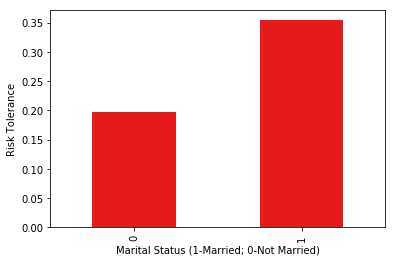

In [191]:
train_data['IsMarried'] = train_data.MARRIED.map({1:1,2:0})
train_data.groupby('IsMarried')['RiskTolerance'].mean().plot(kind='bar')
plt.xlabel('Marital Status (1-Married; 0-Not Married)')
plt.ylabel('Risk Tolerance')

#### OCCAT2: 
Although hierarchy/order is associated with occupation levels, the ordering of category values in the column is not proper (e.g. Technical & Sales roles are grouped as 2). Thus, let's consider it as a nominal category and perform One-hot encoding (as cardinality is only 4).

Text(0,0.5,'Count')

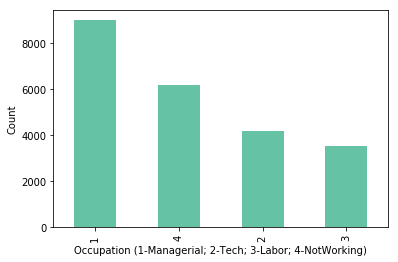

In [256]:
train_data.OCCAT2.value_counts().plot(kind='bar')
plt.xlabel('Occupation (1-Managerial; 2-Tech; 3-Labor; 4-NotWorking)')
plt.ylabel('Count')

In [193]:
train_data['Occupation'] = train_data.OCCAT2.map({1:'Occu_MngProf',2:'Occu_TechSalServ',3:'Occu_Other',4:'Occu_NotWorking'})
Occupation = pd.get_dummies(train_data.Occupation)
Occupation.drop('Occu_NotWorking', inplace=True, axis=1)
Occupation.value_counts()

Occu_MngProf  Occu_Other  Occu_TechSalServ
1             0           0                   8981
0             0           0                   6163
                          1                   4181
              1           0                   3522
dtype: int64

In [194]:
train_data = pd.concat([train_data, Occupation], axis=1)

In [195]:
train_data.groupby(['Occu_MngProf','Occu_TechSalServ','Occu_Other'])['RiskTolerance'].mean()

Occu_MngProf  Occu_TechSalServ  Occu_Other
0             0                 0             0.228809
                                1             0.198800
              1                 0             0.243835
1             0                 0             0.403656
Name: RiskTolerance, dtype: float64

Occupation-wise RiskTolerance levels:
Managerial/Professional  > Technical/Sales/Service > Other workers

#### INCOME: As it's right skewed (chart below), log transformation can convert it into Guassian distribution

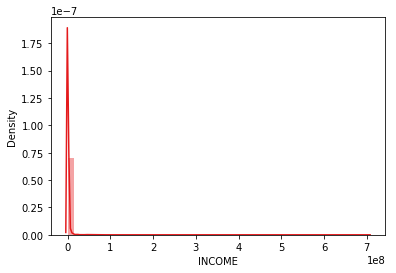

In [196]:
sb.distplot(train_data.INCOME, kde=True)

In [197]:
train_data.INCOME.describe()

count    2.284700e+04
mean     1.008232e+06
std      1.116354e+07
min      0.000000e+00
25%      3.747692e+04
50%      8.144943e+04
75%      2.036236e+05
max      7.035907e+08
Name: INCOME, dtype: float64

As INCOME has 0 as minimum, simple log transformation can't be applied. Thus, we use np.log1p() as below, to get log(1+INCOME)

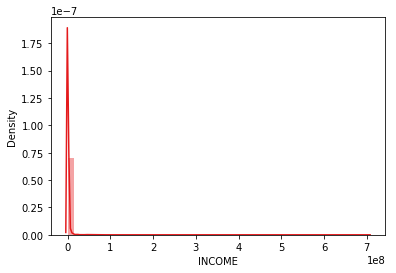

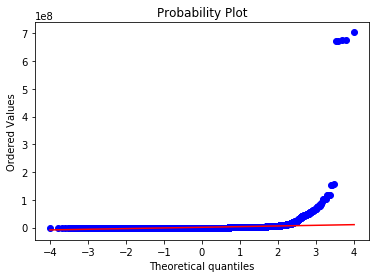

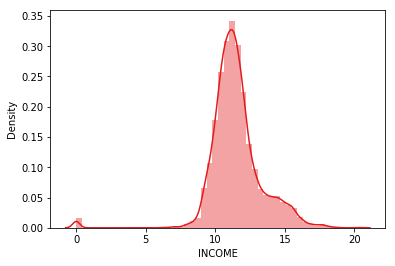

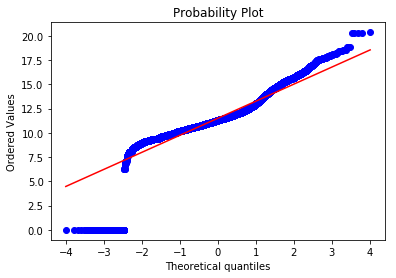

In [198]:
sb.distplot(train_data.INCOME, kde=True)
plt.show()
stats.probplot(train_data.INCOME, dist = 'norm', plot=pylab)
plt.show()
sb.distplot(np.log1p(train_data.INCOME), kde=True)
plt.show()
stats.probplot(np.log1p(train_data.INCOME), dist = 'norm', plot=pylab)
plt.show()

In [267]:
train_data['INCOME'] = np.log1p(train_data['INCOME'])

In [268]:
train_data['INCOME'].describe()

count    22847.000000
mean        11.515359
std          1.884347
min          0.000000
25%         10.531503
50%         11.307750
75%         12.224033
max         20.371707
Name: INCOME, dtype: float64

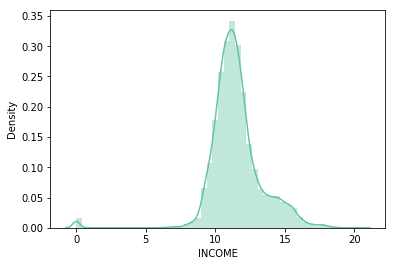

In [269]:
sb.distplot(train_data['INCOME'])

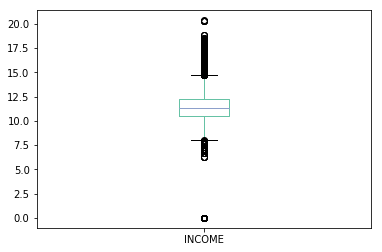

In [270]:
train_data['INCOME'].plot(kind='box')

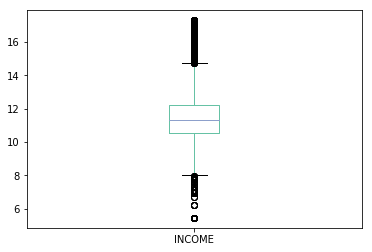

In [271]:
# Clipping extreme outliers (beyond 3*IQR distance from Q1/Q3)

Q3 = train_data['INCOME'].quantile(0.75)
Q1 = train_data['INCOME'].quantile(0.25)
IQR = Q3 - Q1

train_data['INCOME'] = np.where(train_data['INCOME'] > Q3+3*IQR, Q3 + 3*IQR, train_data['INCOME'])
train_data['INCOME'] = np.where(train_data['INCOME'] < Q1-3*IQR, Q1 - 3*IQR, train_data['INCOME'])
train_data['INCOME'].plot(kind='box')

In [272]:
train_data['INCOME'].describe()

count    22847.000000
mean        11.548962
std          1.692023
min          5.453911
25%         10.531503
50%         11.307750
75%         12.224033
max         17.301625
Name: INCOME, dtype: float64

#### NETWORTH: Although it's also right skewed, we can't apply log transformation as some families have negative networth. Thus, let's categorise the values into 10 bins based on percentiles.

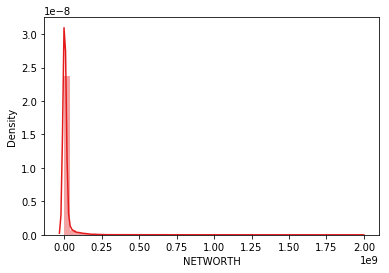

In [218]:
sb.distplot(train_data.NETWORTH)

In [220]:
train_data.NETWORTH.describe()

count    2.284700e+04
mean     1.384761e+07
std      8.000336e+07
min     -9.555000e+05
25%      2.393500e+04
50%      2.406000e+05
75%      1.640850e+06
max      1.967199e+09
Name: NETWORTH, dtype: float64

In [221]:
# Converting Networth column into bins
train_data['Networth_bin'] = np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.1), 1, 
                                 np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.2), 2, 
                                   np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.3), 3, 
                                     np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.4), 4, 
                                        np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.5), 5, 
                                          np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.6), 6, 
                                            np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.7), 7, 
                                              np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.8), 8, 
                                                np.where(train_data.NETWORTH < train_data.NETWORTH.quantile(0.9),9, 10)))))))))
train_data['Networth_bin'].value_counts()

2     2290
9     2286
7     2286
10    2285
5     2285
4     2285
6     2284
8     2283
3     2283
1     2280
Name: Networth_bin, dtype: int64

#### EXPENSHILO: Reclassify as follows: unusually low(3), normal(2), unusually high(1)

In [222]:
train_data.EXPENSHILO.value_counts()

3    16924
1     5065
2      858
Name: EXPENSHILO, dtype: int64

In [223]:
#Reordering the values
train_data.EXPENSHILO = train_data.EXPENSHILO.map({1:1, 3:2, 2:3})
train_data.EXPENSHILO.value_counts()

2    16924
1     5065
3      858
Name: EXPENSHILO, dtype: int64

#### KNOWL : Reclassify 'not at all knowledgeable' as 0 (from -1). Retain the other values from 1 to 10.

In [224]:
train_data.KNOWL.value_counts()

 10    4758
 8     4589
 7     3943
 9     2812
 5     2553
 6     2385
 4      758
 3      459
 2      263
-1      195
 1      132
Name: KNOWL, dtype: int64

In [225]:
train_data.KNOWL.replace({-1:0},inplace=True)
train_data.KNOWL.value_counts()

10    4758
8     4589
7     3943
9     2812
5     2553
6     2385
4      758
3      459
2      263
0      195
1      132
Name: KNOWL, dtype: int64

#### YESFINRISK & NOFINRISK

In [226]:
pd.crosstab(train_data['YESFINRISK'],train_data['NOFINRISK'])

NOFINRISK,0,1
YESFINRISK,,
0,14546,7168
1,1133,0


YESFINRISK represents willingess to take substantial risk, and NOFINRISK represents aversion to risk. Thus, we can combine both columns into a new column 'FINRISK' as follows: 
    - 1, if YESFINRISK is 1 (i.e. high risk taker)
    - 3, if NOFINRISK is 1  (i.e. risk averse)
    - 2, if both YESFINRISK and NOFINRISK are 0 (i.e. neither high risk nor aversion)

In [227]:
train_data['FINRISK'] = np.where(train_data.YESFINRISK == 1, 1, np.where(train_data.NOFINRISK == 0, 2, 3)) 
                        
train_data['FINRISK'].value_counts()

2    14546
3     7168
1     1133
Name: FINRISK, dtype: int64

In [266]:
train_data.groupby('ANYPEN')['RiskTolerance'].mean()

ANYPEN
0    0.166206
1    0.388240
Name: RiskTolerance, dtype: float64

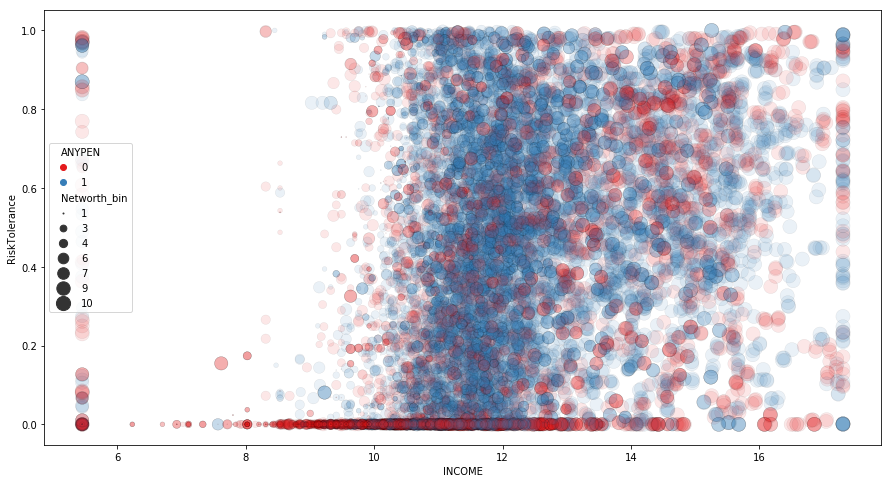

In [282]:
plt.figure(figsize=(15,8))
sb.scatterplot(data=train_data,x='INCOME',y='RiskTolerance', hue='ANYPEN', palette='Set1', size='Networth_bin', sizes=(1,200), 
               alpha=0.1, edgecolor='black')

#### Key Observations:
1. The red circles (ANYPEN=0) are more concentrated at 0 Risk Tolerance level. i.e. Those who don't have any pension plan are more inclined to avoid any type of risk
2. Smaller circles are more concentrated in bottom half of the chart, and bigger circles in top half of the chart. i.e. As networth (size of circle) increases, risk tolerance levels also increased
3. Similarly, as we move from left to right, the no. of circles in the upper half of the chart increased i.e. with increase in income levels, risk tolerance increases too
4. As we had clipped the INCOME outliers on both ends, we see a series of circles lined up on both (left & right) ends of the chart

## Consolidating all feature-engineered columns into train_data

In [283]:
train_data.head()

,HHSEX,AGE,EDCL,MARRIED,KIDS,OCCAT2,INCOME,NETWORTH,ANYPEN,EXPENSHILO,...,sex_male,IsMarried,Occupation,Occu_MngProf,Occu_Other,Occu_TechSalServ,INCOME_log,INCOME_final,Networth_bin,FINRISK
25885,1,61,4,1,1,1,12.833525,9197881.0,1,2,...,1,1,Occu_MngProf,1,0,0,12.833525,12.833525,9,2
8088,1,76,4,1,0,3,10.896021,832500.0,1,1,...,1,1,Occu_Other,0,1,0,10.896021,10.896021,7,2
13999,2,93,2,2,0,4,10.880812,1730000.0,1,2,...,0,0,Occu_NotWorking,0,0,0,10.880812,10.880812,8,3
28515,1,80,1,2,1,3,11.380070,220110.0,0,2,...,1,0,Occu_Other,0,1,0,11.380070,11.380070,5,3
5383,1,58,4,1,0,4,13.140321,43903000.0,1,2,...,1,1,Occu_NotWorking,0,0,0,13.140321,13.140321,10,2


In [287]:
# Dropping the columns that are not required anymore
train_data.drop(['HHSEX','MARRIED','OCCAT2', 'Occupation','NETWORTH', 'YESFINRISK', 'NOFINRISK'], axis=1, inplace=True)

# Reordering the final columns
cols = ['sex_male','AGE','EDCL','Occu_MngProf','Occu_TechSalServ','Occu_Other','IsMarried','KIDS','INCOME','Networth_bin','ANYPEN','EXPENSHILO','BNKRUPLAST5','FORECLLAST5','SPENDMOR','SPENDLESS','KNOWL','FINRISK','RiskTolerance']
train_data = train_data[cols]

print(train_data.shape)
train_data.head()

(22847, 19)


,sex_male,AGE,EDCL,Occu_MngProf,Occu_TechSalServ,Occu_Other,IsMarried,KIDS,INCOME,Networth_bin,ANYPEN,EXPENSHILO,BNKRUPLAST5,FORECLLAST5,SPENDMOR,SPENDLESS,KNOWL,FINRISK,RiskTolerance
25885,1,61,4,1,0,0,1,1,12.833525,9,1,2,0,0,5,4,9,2,0.477644
8088,1,76,4,0,0,1,1,0,10.896021,7,1,1,0,0,5,1,5,2,0.393474
13999,0,93,2,0,0,0,0,0,10.880812,8,1,2,0,0,5,1,8,3,0.948454
28515,1,80,1,0,0,1,0,1,11.380070,5,0,2,0,0,5,5,5,3,0.000000
5383,1,58,4,0,0,0,1,0,13.140321,10,1,2,0,0,2,1,10,2,0.589254


In [288]:
x_train = train_data.drop('RiskTolerance', axis=1)
y_train = train_data['RiskTolerance']

## Checking for multi-collinearity among features

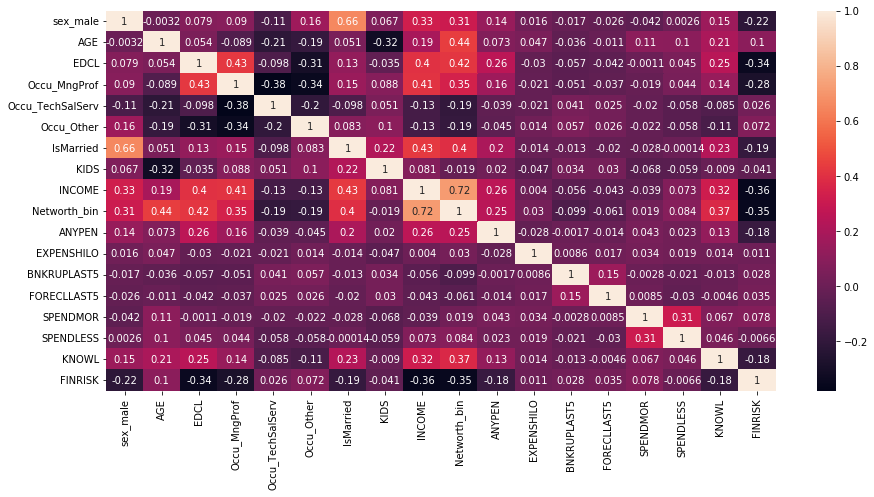

In [289]:
plt.figure(figsize=(15,7))
sb.heatmap(x_train.corr(),annot=True)

As the correlation among the features above didn't exceed 0.8 (in absolute value), there is no significant multi-collinearity in the features and thus we can retain all of them.

### Applying same feature engineering on the test data

In [290]:
test_data['sex_male'] = test_data['HHSEX'].map({1:1,2:0})
test_data['IsMarried'] = test_data.MARRIED.map({1:1,2:0})
test_data['Occupation'] = test_data.OCCAT2.map({1:'Occup_MngProf',2:'Occu_TechSalServ',3:'Occu_Other',4:'Occu_NotWorking'})
Occupation = pd.get_dummies(test_data.Occupation)
Occupation.drop('Occu_NotWorking', inplace=True, axis=1)
Occupation.value_counts()
test_data['INCOME'] = np.log1p(test_data['INCOME'])
test_data['Networth_bin'] = np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.1), 1, 
                                 np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.2), 2, 
                                   np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.3), 3, 
                                     np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.4), 4, 
                                        np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.5), 5, 
                                          np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.6), 6, 
                                            np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.7), 7, 
                                              np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.8), 8, 
                                                np.where(test_data.NETWORTH < test_data.NETWORTH.quantile(0.9),9, 10)))))))))
test_data.EXPENSHILO = test_data.EXPENSHILO.map({1:1, 3:2, 2:3})
test_data.KNOWL.replace({-1:0},inplace=True)
test_data['FINRISK'] = np.where(test_data.YESFINRISK == 1, 1, np.where(test_data.NOFINRISK == 0, 2, 3)) 
test_data.drop(['HHSEX','MARRIED','OCCAT2', 'Occupation','NETWORTH', 'YESFINRISK', 'NOFINRISK'], axis=1, inplace=True)
test_data = pd.concat([test_data, Occupation], axis=1)

#Reordering the columns
cols = ['sex_male','AGE','EDCL','Occup_MngProf','Occu_TechSalServ','Occu_Other','IsMarried','KIDS','INCOME','Networth_bin','ANYPEN','EXPENSHILO','BNKRUPLAST5','FORECLLAST5','SPENDMOR','SPENDLESS','KNOWL','FINRISK','RiskTolerance']
test_data = test_data[cols]

x_test = test_data.drop('RiskTolerance', axis=1)
y_test = test_data['RiskTolerance']

x_test.shape, y_test.shape

((5712, 18), (5712,))

## Model Construction

In [291]:
num_folds = 10
scoring = 'r2'
validation_size = 0.2
seed = 3

In [292]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Ensemble Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

#Multi-layer Perceptron
models.append(('MLP', MLPRegressor()))

In [293]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

LR: 0.351974 (0.017148)
LASSO: -0.000424 (0.000530)
EN: 0.009922 (0.002347)


C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", lin

C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", lin

KNN: nan (nan)
DTR: 0.797098 (0.025862)
SVR: 0.350668 (0.019775)
ABR: 0.307481 (0.022035)
GBR: 0.407393 (0.016881)
RFR: 0.849858 (0.012362)
ETR: 0.851440 (0.015797)
MLP: 0.308095 (0.104854)


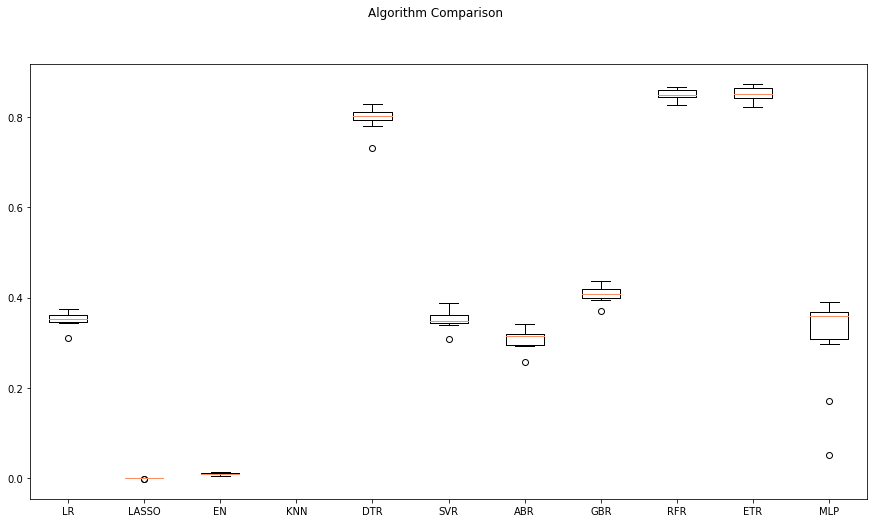

In [295]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Tuning Hyperparameters
As we see above, the RandomForestRegressor and ExtraTreesRegressor are the best performing models, we will further tune their hyperparameters to increase the scoring.

In [296]:
#Tuning RandomForestRegressor

print(datetime.now()) #just to check the time taken

param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600]}

model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)
randomCV = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold, verbose=2, random_state = 42, n_jobs=1)
randomCV_reg = randomCV.fit(x_train, y_train)

print("Best: %f using %s" % (randomCV_reg.best_score_, randomCV_reg.best_params_))

means = randomCV_reg.cv_results_['mean_test_score']
stds = randomCV_reg.cv_results_['std_test_score']
params = randomCV_reg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(datetime.now()) #just to check the time taken

2022-04-06 02:14:29.479749


C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ...................................n_estimators=100; total time=  17.1s
[CV] END ...................................n_estimators=100; total time=  16.9s
[CV] END ...................................n_estimators=100; total time=  17.9s
[CV] END ...................................n_estimators=100; total time=  17.7s
[CV] END ...................................n_estimators=100; total time=  17.3s
[CV] END ...................................n_estimators=100; total time=  18.8s
[CV] END ...................................n_estimators=100; total time=  17.1s
[CV] END ...................................n_estimators=100; total time=  16.7s
[CV] END ...................................n_estimators=100; total time=  15.9s
[CV] END ...................................n_estimators=100; total time=  16.4s
[CV] END ...................................n_estimators=200; total time=  32.5s
[CV] END ...................................n_es

C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\sr

Best: 0.850454 using {'n_estimators': 300}
0.849314 (0.012304) with: {'n_estimators': 100}
0.850136 (0.012586) with: {'n_estimators': 200}
0.850454 (0.012651) with: {'n_estimators': 300}
0.850272 (0.012690) with: {'n_estimators': 400}
0.850000 (0.012660) with: {'n_estimators': 500}
nan (nan) with: {'n_estimators': 600}
2022-04-06 03:12:35.088114


In [297]:
y_pred = randomCV_reg.predict(x_test)
print(r2_score(y_test,y_pred))

0.8463039657131461


In [307]:
# Tuning ExtraTreesRegressor 

print(datetime.now()) #just to check the time taken

param_grid = {'n_estimators': [250,300,350,400,450,500]}
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds)
randomCV_etr = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold, verbose=2, random_state = 42, n_jobs=1)
randomCV_reg_etr = randomCV_etr.fit(x_train, y_train)

print("Best: %f using %s" % (randomCV_reg_etr.best_score_, randomCV_reg_etr.best_params_))

means = randomCV_reg_etr.cv_results_['mean_test_score']
stds = randomCV_reg_etr.cv_results_['std_test_score']
params = randomCV_reg_etr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(datetime.now()) #just to check the time taken

2022-04-06 03:52:51.719338


C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ...................................n_estimators=250; total time=  17.4s
[CV] END ...................................n_estimators=250; total time=  18.0s
[CV] END ...................................n_estimators=250; total time=  17.3s
[CV] END ...................................n_estimators=250; total time=  17.4s
[CV] END ...................................n_estimators=250; total time=  17.1s
[CV] END ...................................n_estimators=250; total time=  18.2s
[CV] END ...................................n_estimators=250; total time=  18.1s
[CV] END ...................................n_estimators=250; total time=  18.3s
[CV] END ...................................n_estimators=250; total time=  17.8s
[CV] END ...................................n_estimators=250; total time=  19.2s
[CV] END ...................................n_estimators=300; total time=  18.2s
[CV] END ...................................n_es

C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\sreevathsa\Anaconda3\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\sr

MemoryError: could not allocate 786432 bytes

In [299]:
randomCV_reg_etr.best_score_

0.6558882162972134

In [300]:
randomCV_reg_etr.best_estimator_

ExtraTreesRegressor(max_depth=30, min_samples_leaf=10, min_samples_split=3,
                    n_estimators=600)

In [301]:
best_etr = randomCV_reg_etr.best_estimator_
y_pred = best_etr.predict(x_test)
print(r2_score(y_test,y_pred))

0.6669132716469106


#### Overall, ExtraTreeRegressor model outperformed RandomForestRegressor by a thin margin, and we will use it further for determining important features and will deploy it as final model.

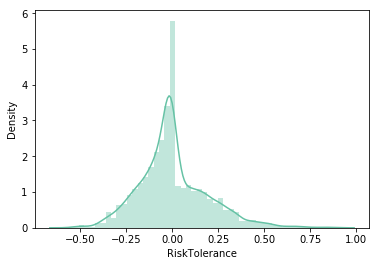

In [302]:
sb.distplot(y_test - y_pred)

The residuals fall in a normally distribution.

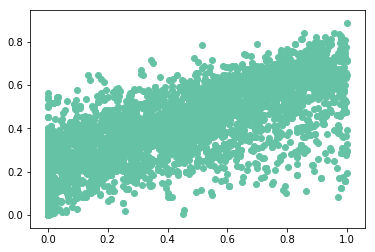

In [303]:
plt.scatter(y_test, y_pred)

## Feature Importance

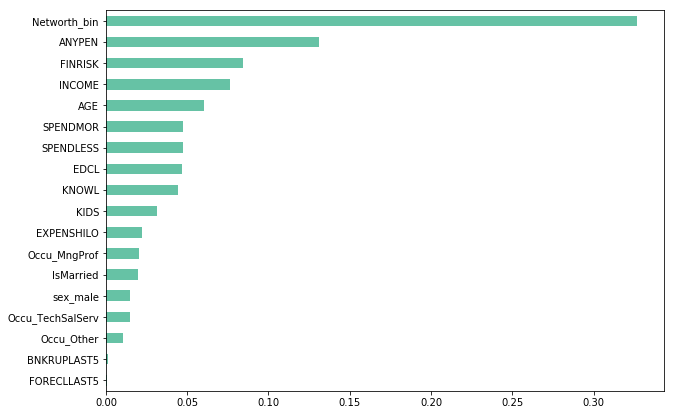

In [304]:
pd.Series(best_etr.feature_importances_, index = x_train.columns).sort_values().plot(kind='barh', figsize=(10,7))

As we can observe, Networth percentile (bin), Age, Income, AnyPension and Willingness to take financial risk are the top 5 most important features in determining the RiskTolerance levels of individuals.

## Saving the model

In [305]:
file = open('final_risk_tolerance_model.pkl', 'wb')

# dump information to that file
pickle.dump(best_etr, file)

In [306]:
# reopen the file to cross check if the model is saved properly
file = open('final_risk_tolerance_model.pkl','rb')
model = pickle.load(file)

y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.6669132716469106

## Conclusion:
- Thus, we could model the investment risk tolerance of investors, based on their demographic, financial and behavioural aspects with ~85% explanatory power. 
- The key features are  networth, income, age, having a pension plan and willingess to take risk (as are highlighted by several literature).
- Further study and improvements can be done by collecting more data through emerging robo-advisory platforms, and implementing deep learning techniques.